# Introduction

Dear Machine Learners,

* This is my first time using *BERT* & *HuggingFace*, therefore I have decided to share this journey of discovery...
* In this notebook, you will learn about the *BERT* model and its implementation with *TensorFlow, Keras* and *HuggingFace* to solve this competitions problematic.
* I also haven't used *Kaggle* in a long time...
* In this notebook, you will learn how to implement models for scoring, without the internet (a rule of this competition).
* Thanks a lot to Jude Tchaye for his [NBME-TensorFlow-Bert-Baseline notebook](https://www.kaggle.com/code/tchaye59/nbme-tensorflow-bert-baseline) which I enriched with comments and ressources.
* If you notice errors (english mistakes included) or have any questions do not hesitate to comment.

Happy reading !

# Environment

In this part, we will understand the constraints of our working environment, and set a few things up.

## Importing libraries

Well, you probably already know about this...

* *Imports the libraries for the project:*

In [ ]:
import os
import numpy as np
import pandas as pd
import random
from sklearn.preprocessing import LabelEncoder
from tqdm.auto import tqdm
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
import tensorflow.keras.backend as K
from tensorflow.keras import mixed_precision
import tensorflow_addons as tfa
import dill
import matplotlib.pyplot as plt
import transformers
from transformers import AutoTokenizer, AutoConfig,TFAutoModel
import json
import matplotlib.pyplot as plt

## Using *Kaggle notebooks* & Competition Rules

*To recap: in order to have access to the model while scoring we've added the outputs of this notebook to its inputs so that the output files persist when comitting*.

If like me, you haven't participated in a competition nor used the *Kaggle notebooks* in a while, this part should be of interest to you:
* In order to submit *predictions* for scoring, we must provide a *Kaggle notebook* which outputs a "predictions.csv" file, with the required formating (*a prediction sample is provided, see the [competitions rules](https://www.kaggle.com/competitions/nbme-score-clinical-patient-notes/overview/evaluation)*)...
* When you submit, you actually launch a run of the *notebook*.
* One important rule of the competition is: for *scoring*, the *notebook run* is happening *offline* (*the Internet setting must be off*, this is a rule of the competition)...
* Which means that the *notebook run*, which is happening on the *Kaggle servers* won't be able to download models directly from the internet.
* For this reason, we did add the *Output* of this *notebook* as an *Input* of this very same *notebook*. This means that the files outputed by the *notebook* during *Save & Run* will persist on the *Kaggle servers* as the *inputs* if the output files are *comitted*...
* Note that after *commiting, refreshing* the *Input directory* is necessary (in the *notebooks file explorer*).
* Which will enable us to load the model saved on the *Kaggle servers* even if the *Internet setting* is *off*.

When you submit, the test.csv input samples will change so that the model infers on unseen data for scoring.

<img src= "https://i.ibb.co/2Z4m2Gc/submit.png" alt ="Submit" style='width: 400px;'>

## Notebook Parameters

We are initializing the following *parameters* to handle our *notebook configuration*:
1. To ***add your own Dataset***: 
    1. add the **outputs of the cloned notebook to the inputs** ***("+ Add data" button)***,
    2. set **INPUT** to your *notebook name*.
2. To ***train a new model*** for submission: 
    1. set the **MODEL_NAME** to the *HuggingFace model adress*, 
    2. set **TRAIN** to *True*, 
    3. set **RESET** to *True*,
    4. **enable the internet**, 
    5. **save & run** the notebook on *GPU*, 
    6. **refresh the input dataset**.
3. To ***submit for scoring***: 
    1. set **TRAIN** to *False*,
    2. set **RESET** to *False*,
    3. **disable the internet**,
    4. **submit**.
* *Optionnaly,* to ***reset the model & data files for retraining*** & re-downloading the model files from the web (from scracth, also useful if you did not add your input data):
    1. set **TRAIN** to *True*,
    2. set **RESET** to *True*, 
    3. **enable the internet**,
    4. **run** & *experiment*.
* *Optionnaly,* to *experiment with the committed pre-trained model & data*: 
    1. once **the model and data files are committed and refreshed**, 
    2. set **TRAIN** to *True*,
    3. set **RESET** to *False*,
    4. **run** & *experiment*.


* *Sets the notebook parameters:*

In [ ]:
MODEL_NAME = 'roberta-base'
TRAIN = True # True to train and evaluate the model
RESET = True # True to retrain the same model without using committed model files, generates tokens data
INPUT = 'nbme-tensorflow-bert-baseline' # The notebooks name

## Training Parameters

* *Sets the training parameters:*

In [ ]:
TRAIN_SPLIT = 0.8
BATCH_SIZE = 12
EPOCHS = 20
SEQUENCE_LENGTH = 512
SEED = 999

## Data State

* *Computes data state information:*

In [ ]:
input_path = f'../input/{INPUT}/'
output_path = f'./'

if RESET:
    # If not resetting, use the model files already committed
    data_exists = False
else:
    # If reset, generates new data arrays for training
    data_exists = os.path.exists(f'{input_path}/model.h5')

# Prints status
if data_exists:
    print('''
        Model & data found on the Kaggle servers. 
        Model & data will be read from the Kaggle disk. 
        Internet can be disabled and the comitted model can be submitted.
    ''')    
else:
    print('''
        Model & data do not exist on the Kaggle servers.
        Model will be downloaded from the cloud & data generated from scratch.
        Save version with "Save & Run All" to save files on Kaggle.
        If you saved & ran this notebook succesfully, refresh the Kaggle Input Data.
        Set TRAIN, RESET to False & disable internet to Submit.
    ''')

## Parallelization Configuration

This snippet manages settings for the compute configuration, I haven't dived too much into it but it kind of speaks for itself.

* *Selects the appropriate settings for the configuration:*

In [ ]:
# NEW on TPU in TensorFlow 24: shorter cross-compatible TPU/GPU/multi-GPU/cluster-GPU detection code

try: # detect TPUs
    tpu  = tf.distribute.cluster_resolver.TPUClusterResolver.connect() # TPU detection
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
    print('Using TPU')

except ValueError: # detect GPUs
    tpu = None
    strategy = tf.distribute.MirroredStrategy() # for GPU or multi-GPU machines
    #strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
    #strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy() # for clusters of multi-GPU machines

print("Number of accelerators: ", strategy.num_replicas_in_sync)

AUTO = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')

***Note that in order to render the parallelization effective, it is required to call the model building and fitting and predicting functions under a*** *with stragegy.scope():* ***call.***

## Notebook Configuration



* *There should be files in our input directory, including files of the model we trained last (save version using save and run all):*

In [ ]:
os.listdir('../input/nbme-tensorflow-bert-baseline')

* *Sets a few things up:*

In [ ]:
# Prevents Data Sharding
os.environ["TF_GPU_ALLOCATOR"] = "cuda_malloc_async"
options = tf.data.Options()
options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.DATA

# Sets output size for plots
plt.rcParams["figure.figsize"] = (15, 10)

## Setting Seeds

* *Sets the random seeds in order to obtain reproductible results:*

In [ ]:
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Model Introduction

*In this part, I have summarized information about the BERT model, if you're not interested in theory, you should skip it.*

## Transformers

***This article makes for a good general introduction to the model: [BERT Explained: State of the art language model for NLP](https://towardsdatascience.com/bert-explained-state-of-the-art-language-model-for-nlp-f8b21a9b6270).***

The *Google* BERT *(Bidirectional Encoder Representations from Transformers)* model which has been described in the [Attention Is All You Need](https://arxiv.org/pdf/1706.03762.pdf) article, was realease in 2018 and is one of the first transformer model *(following the release of the OpenAI GPT model)*.

<img src= "https://huggingface.co/datasets/huggingface-course/documentation-images/resolve/main/en/chapter1/transformers_chrono.svg" alt ="Timeline" style='width: 800px;'>

[*[Source]*](https://huggingface.co/course/chapter1/4?fw=pt)

The BERT model is a *auto-encoding Transformer* which allows the model to develop "a statistical understanding of the language it has been trained on" whithout requiring human labeling, a major advantage for Natural Langage Processing *(NLP)*, a field in which the labeled datasets are scarse *([How do Transformers work ?](https://huggingface.co/course/chapter1/4?fw=pt))*.

The BERT model has been pre-trained on large amounts of data *(Wikipedia)* on *Causal Language Modeling* & *Masked Language Modeling* tasks to aquire an understanding of the english language. More about the pre-training of the BERT model: [BERT: Pre-training of Deep Bidirectional Transformers for
Language Understanding](https://arxiv.org/pdf/1810.04805.pdf).

It has achieved state-of-the-art performance in numerous NLP tasks, a major breakthrough for the machine learning community. More about the transformers architecture: [Transformer Neural Networks - EXPLAINED! (Attention is all you need)](https://www.youtube.com/watch?v=TQQlZhbC5ps). This article also develops the subject: [Transformers](https://towardsdatascience.com/transformers-89034557de14).

*To simplify, the BERT model understands context by comparing the use of words in various documents.* For a deeper technical understanding of how the the model works, I recommend watching [BERT Neural Network - EXPLAINED!](https://www.youtube.com/watch?v=xI0HHN5XKDo).


We will fine-tune a variant of this model *(Facebook RoBERTa)* on our specific task to participate in the competition.

## RoBERTa

We have chosen the [*RoBERTa*](https://huggingface.co/docs/transformers/model_doc/roberta) model to experiment with, *(in its base configuration: [*RoBERTa base*](https://huggingface.co/roberta-base))*. 

"RoBERTa iterates on BERT's pretraining procedure, including training the model longer, with bigger batches over more data; removing the next sentence prediction objective; training on longer sequences; and dynamically changing the masking pattern applied to the training data." *([*Pytorch Github*](https://github.com/pytorch/fairseq/blob/main/examples/roberta/README.md))*.

***This article summarizes the key differences between BERT & RoBERTa and their effects: [Evolving with BERT: Introduction to RoBERTa](https://medium.com/analytics-vidhya/evolving-with-bert-introduction-to-roberta-5174ec0e7c82).***

## HuggingFace

[*HuggingFace*](https://huggingface.co/) provides, amongts over services, a very handy API *([the transformers library - Pypi](https://pypi.org/project/transformers/))* and a model repository to easily implement *pre-trained* transformers *(transfer learning)*, in combination with *TensorFlow* or *Pytorch*.

In this notebook, we will use the *transformers* library in combination with *TensorFlow* to download the model, tokenizer & configuration, and build a *top layer* to fine-tune the model to our specific task.


## Named-entity Recognition

Let's refer to the [competition description](https://www.kaggle.com/competitions/nbme-score-clinical-patient-notes/overview): "In this competition, you’ll identify specific clinical concepts in patient notes. Specifically, you'll develop an automated method to map clinical concepts from an exam rubric (e.g., “diminished appetite”) to various ways in which these concepts are expressed in clinical patient notes written by medical students (e.g., “eating less,” “clothes fit looser”)".

In a nutshell, our objective is to fine-tune our model to recognize entities. According to *Papers with code*, Named-entity Recognition *(NER)* is "the task of tagging entities in text with their corresponding type." *([Named Entity Recognition](https://paperswithcode.com/task/named-entity-recognition-ner/codeless))*.

<img src= "https://production-media.paperswithcode.com/thumbnails/task/task-0000000008-1eee4fae_Kb2RSZl.jpg" alt ="Example" style='width: 300px;'>

[*[Source]*](https://paperswithcode.com/task/named-entity-recognition-ner/codeless)

To do so, we will need to pass the appropriate embeddings to our model.

## Embeddings

In order to fine-tune the model, embeddings, which are numerical representations of the (textual) data *(as with any machine learning model)* are passed to the transformer model.

The embeddings are vectors that numericaly describe the characteristics of the data for the model to learn from. Here is an example for you to grasp what embeddings are:

<img src= "https://www.researchgate.net/profile/Akbar-Karimi-4/publication/338934952/figure/fig2/AS:853247933808640@1580441568270/BERT-word-embedding-layer-Devlin-et-al-2018.ppm" alt ="Embeddings" style='width: 800px;'>

[*[Source]*](https://www.researchgate.net/profile/Akbar-Karimi-4/publication/338934952/figure/fig2/AS:853247933808640@1580441568270/BERT-word-embedding-layer-Devlin-et-al-2018.ppm)

For our Named-entity Recognition task, we will use a variation of these embeddings:
* Token embeddings that encodes the various words of our corpus documents thanks to a *Tokenizer*,
* Positional embeddings which point to the indexes of the targets *(portions of the text that we aim to recognize the named-entities of)*,
* Target embeddings with the actual labels of the target text portions to train our model (encoded with a *LabelEncoder*),
* We won't use the Segments embeddings.

In order to implement the *Tokenization*, we will use the *transformers library from HuggingFace*.

## Processing

One of the main perks of BERT is that it requires fery few data preprocessing, thanks to the *Tokenizer class*: "this tokenizer applies an end-to-end, text string to wordpiece tokenization. It first applies basic tokenization, followed by wordpiece tokenization." *([Tensorflow documentation](https://www.tensorflow.org/text/api_docs/python/text/BertTokenizer))*. *Note that in the case of RoBERTa, the tokenization model used is BPE.*

As we are using a pre-trained model from *HuggingFace*, the *Tokenizer* is included with its presets. The *Tokenizer* also allows for the inverse transformation of the *models logits* thanks to its *Decoder* component.

***If you are interested in understanding how the Tokenizer itself works, this HuggingFace article explains it all: [The tokenization pipeline](https://huggingface.co/docs/tokenizers/python/latest/pipeline.html#example).***

To wrap it up, the transformers pipeline is pretty simple:

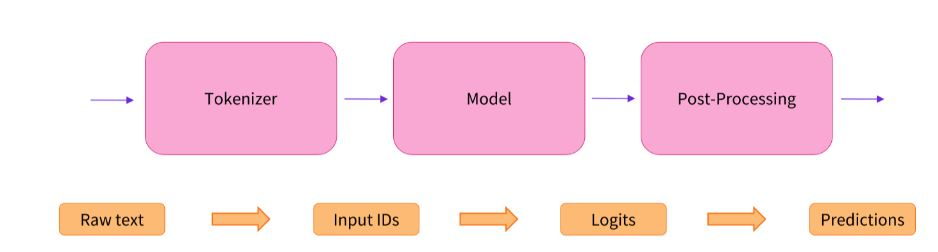

# Data

*In this part, we will explore the competition data to understand what we are trying to predict in order to preprocess the data correctly.*

## Description

A description of the data and a *data dictionary* are available at the following adress: [data dictionary](https://www.kaggle.com/competitions/nbme-score-clinical-patient-notes/data).

 ## Loading

The data is constituted of 5 *.csv* files.

* *Loads the data:*

In [ ]:
# Input competition data path
data_input_path = '../input/nbme-score-clinical-patient-notes'

# Loads the data using Pandas
features = pd.read_csv(f'{data_input_path}/features.csv')
patient_notes = pd.read_csv(f'{data_input_path}/patient_notes.csv')
test = pd.read_csv(f'{data_input_path}/test.csv')
train = pd.read_csv(f'{data_input_path}/train.csv')
sample_submission= pd.read_csv(f'{data_input_path}/sample_submission.csv')

## Quick Peak

*Let's take a look a the actual dataframes !*

### Train Dataset

We print the *train* head out:

In [ ]:
train.head()

* The *case_num* corresponds to a single "patient" with its unique caracteristics and history.

In [ ]:
train.describe(include='all')

### Patient notes

We print the *patient_notes* head out:

In [ ]:
patient_notes.head()

* Each *pn_history* is a note written by the medical students taking the test,
* *pn_num* ids each of these *pn_history* notes.

In [ ]:
patient_notes.describe(include='all')

### Features

Features are the targets we are trying to predict. In combination with the locations of the 

In [ ]:
features.head()

* *feature_text* are our targets: the symptoms that we will try to predict using the students notes,
* The *feature_num* ids each of these *feature_text*.

In [ ]:
features.describe(include='all')

## Test & Sample Submission

In [ ]:
sample_submission

In [ ]:
test

* For each patient note, the objective is to predict the span (portion) of the note that correspond to each feature.
* For example, for the first sample *(00016_000)*, the goal is to find the span of the feature *n°0* for the case *n°0*, in the note *n°16.*

# Preprocessing

## Merge

As you've understood, we have 3 tables of relational data. We will now merge the tables to create a flat dataset in order to train a machine learning algorithm.

<img src= "https://i.ibb.co/Cbrvsx8/flat.png" alt ="Embeddings" style='width: 300px;'>

* *Generates a flat dataset by merging the various tables:*

In [ ]:
# Merges the patient_notes & features onto the train & test data
train = train.merge(patient_notes,on=['case_num', 'pn_num']).merge(features,on=['case_num', 'feature_num'])
test = test.merge(patient_notes,on=['case_num', 'pn_num']).merge(features,on=['case_num', 'feature_num'])

* *Prints the results head out:*

In [ ]:
train.head(5)

In [ ]:
train.describe()

# Targets LabelEncoder

In order to pass the human readable target data to the machine learning model, we must convert it to numerical data. We use a *LabelEncoder* to transform the data.
* *Loads or generates the LabelEncoder and transforms the target data:*

In [ ]:
EMPTY =  'EMPTY'
CLASSES = [EMPTY,]+features.feature_num.unique().tolist()

if data_exists:
    # If data exsists, loads the LabelEncoder from disk
    label_encoder = dill.load(open(f'{input_path}/label_encoder.dill','rb'))
else:
    # Else, generates & fits a new LabelEncoder
    label_encoder = LabelEncoder()
    label_encoder.fit(CLASSES)
    dill.dump(label_encoder,open(f'{output_path}/label_encoder.dill','wb'))
    
# Transforms the train & test target data
train['TARGET']= label_encoder.transform(train['feature_num'])
test['TARGET']= label_encoder.transform(test['feature_num'])
N_CLASSES = len(label_encoder.classes_)
EMPTY_IDX = label_encoder.transform([EMPTY,]) [0]

In [ ]:
train.head()

# Features Tokenizer

A *Tokenizer* preprocesses the data so that the model can ingest it.
* Loads the *Tokenizer* from *HuggingFace*:

In [ ]:
if data_exists:
    # If data exsists, loads the Tokenizer from disk
    tokenizer = AutoTokenizer.from_pretrained(f'{input_path}/my_tokenizer',normalization=True)
else:
    # Else, downloads & initializes the Tokenizer from the cloud
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME,normalization=True)
    tokenizer.save_pretrained(f'{output_path}/my_tokenizer')

This is an utility function to decode the locations.
* *Decodes the locations:* 

In [ ]:
def decode_location(locations):

    for x in ["[", "]", "'"]:
        locations = locations.replace(x,'')
    locations = locations.replace(',', ';')
    locations = locations.split(";")
    res = []
    for location in locations:
        if location:
            x, y = location.split()
            res.append((int(x), int(y)))
    return sorted(res, key=lambda x:x[0])
    

In [ ]:
if data_exists:
    # Loads data if it already exists on disk
    sequences = np.load(open(f'{input_path}/sequences.npy','rb'))
    masks = np.load(open(f'{input_path}/masks.npy','rb'))
    labels = np.load(open(f'{input_path}/labels.npy','rb'))
else:
    # Initialize the lists
    sequences, labels, masks = [], [], []
    # Groups dataframe by 'pn_num' and iterates over each object
    for g1 in tqdm(train.groupby('pn_num')):
        # Get the grouped dataframe
        gdf = g1[1]
        # Get whole history note text for each patient
        pn_history  = gdf.iloc[0].pn_history

        # Apply the tokenizer on the patient history text
        tokens = tokenizer.encode_plus(
            pn_history,
            max_length=SEQUENCE_LENGTH,
            padding='max_length',
            truncation=True,
            return_offsets_mapping=True)
        # Build the sequence as the tokens input ids according to the sequence lenght
        sequence = tokens['input_ids']
        attention_mask = tokens['attention_mask']
        # Initialize the empty labels
        label = np.array([EMPTY_IDX for _ in range(SEQUENCE_LENGTH)])

        # BUILDS THE TARGET ARRAY
        # Getting the tokens
        offsets = tokens['offset_mapping']
        label_empty = True
        for index, row in gdf.iterrows():
            TARGET = row.TARGET
            # Setting the targets onto the empty labels
            for i, (w_start, w_end) in enumerate(offsets):
                for start,end in decode_location(row.location):
                    if w_start < w_end and (w_start >= start) and (end >= w_end):
                        label[i] = TARGET
                        label_empty = False
                    if w_start >= w_end:
                        break
        # Appending embeddings
        if not label_empty:
            sequences.append(sequence)
            masks.append(attention_mask)
            labels.append(label)
        
    # Formats the data
    sequences = np.array(sequences).astype(np.int32)
    masks = np.array(masks).astype(np.uint8)
    labels = np.array(tf.keras.utils.to_categorical(labels,N_CLASSES)).astype(np.uint8)

    # Saves the data to disk
    np.save(open(f'{output_path}/sequences.npy','wb'), sequences)
    np.save(open(f'{output_path}/masks.npy','wb'), masks)
    np.save(open(f'{output_path}/labels.npy','wb'), labels)

Let's observe what is actually happening during the *tokenization*.
* *Prints the last pn_history:*

In [ ]:
pn_history

* *Prints the last sequence:*

In [ ]:
np.array(sequence)

These are the *input_ids*, the *SEQUENCE_LENGHT* being 512, we can notice that the terms of the document have been encoded, while the last half of it are encoded with the empty *input_id* (1).

* *Prints the last attention_mask:*

In [ ]:
np.array(attention_mask)

Well, kind of the same thing here, except that we only have *1s*, where the model will apply its attention on, and zeroes, where it won't.

* *Prints the last label embeddings:*

In [ ]:
label

Again, in the first half of the embedding, empty labels are encoded with 143, the other ids encode the features of the dataset.

* [About the *HuggingFace Tokenizer encode plus* use](https://stackoverflow.com/questions/61708486/whats-difference-between-tokenizer-encode-and-tokenizer-encode-plus-in-hugging)
* [More About the BERT Tokenizers](https://www.analyticsvidhya.com/blog/2021/09/an-explanatory-guide-to-bert-tokenizer/)

# Model Training

* *Converts the embeddings to a TensorFlow dataset:*

In [ ]:
# Builds the TensorFlow dataset with the embeddings arrays
train_dataset = tf.data.Dataset.from_tensor_slices(
        ((sequences, masks), labels))

* [About *TensorFlow datasets*](https://www.tensorflow.org/api_docs/python/tf/data/Dataset)

## Validation

We are going to generate a validation dataset by applying a split on the *train dataset*. This will enable us to calibrate the model. In order to apply the plit onto the *TensorFlow* dataset, we must use the *TensorFlow* methods *([Source for the function below](https://towardsdatascience.com/how-to-split-a-tensorflow-dataset-into-train-validation-and-test-sets-526c8dd29438))*.

* *Splits the TensorFlow dataset:*

In [ ]:
def get_dataset_partitions_tf(ds, ds_size, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    if shuffle:
        # Specify seed to always have the same split distribution between runs
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

We keep 80% of the data for training and 20% for validation.
* *Generates training & validation datasets:*

In [ ]:
samples = sequences.shape[0]
train_dataset, val_dataset, test_df = get_dataset_partitions_tf(
    train_dataset,
    train_split=TRAIN_SPLIT,
    val_split=0.2,
    test_split=0,
    ds_size=samples)

train_dataset, val_dataset

We use the *TensorFlow* datasets to create generators *with options* which will enable for parallel GPUs training.

***Note that as we are implementing generators to pass the data to the model, the batch_size parameter is set during the generators initialization, not during model fit.***

* *Creates TensorFlow generators:*

In [ ]:
# Creates repeating generators with options and the set batch sizer with the datasets
train_dataset = train_dataset.repeat().batch(BATCH_SIZE).with_options(options)
val_dataset = val_dataset.repeat().batch(BATCH_SIZE).with_options(options)

train_dataset, val_dataset

Another specificity of using generators: we must calculate the steps per epochs for both datasets (for the validation dataset, they're called "validation steps"). These variables will be passed to the fit function.
* *Computes numbers of steps to pass to the step function:*

In [ ]:
steps_per_epoch = (samples * TRAIN_SPLIT) // BATCH_SIZE
validation_steps = (samples * (1 - TRAIN_SPLIT)) // BATCH_SIZE

steps_per_epoch, validation_steps

* [About *TensorFlow distributed datasets*](https://www.tensorflow.org/api_docs/python/tf/distribute/DistributedDataset)

## Callbacks

In addition, we implemented callbakcs:
* *EarlyStopping*: stops the model training if the performance of the model is not improving.
* *ModelCheckpoint*: saves the weights of the best model on disk (*best epoch*).
* *LearningRateScheduler*: implements the learning rate decay at each epoch.

### Early Stopping

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='loss',
    mode='min',
    patience=3)

### Model Checkpoint

In [ ]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    f'{output_path}/model.h5',
    monitor="f1_score",
    verbose=0,
    save_best_only=True,
    save_weights_only=True,
    mode="max",
    save_freq="epoch",
    options=None,
    initial_value_threshold=None)

* *Creates the list of callbacks:*

In [ ]:
callbacks = [early_stopping, model_checkpoint]

# Model Training

## Model Configuration

* Loads the transfomers configuration:

In [ ]:
if data_exists:
    # If data exsists, loads the config from disk
    config = AutoConfig.from_pretrained(f'{input_path}/my_tokenizer/config.json')
else:
    # Else, downloads & initializes the config from the cloud
    config = AutoConfig.from_pretrained(MODEL_NAME)
    config.save_pretrained(f'{output_path}/my_tokenizer')

* *Prints the configuration:*

In [ ]:
config

## Build

To build the model, we use the *HuggingFace & TensorFlow APIs*: we've already used the *HuggingFace API* to import the *Tokenizer* & preprocess the data. We will now use the API to import the pre-trained model as a *TensorFlow* model.

We use the *functional TensorFlow API* to integrate the *pre-trained BERT model* &:
* build the input layer of the network,
* build the output layer of the network,
* compile the model.

* *Builds the ready for training model:*

In [ ]:
def build_model(data_exists, config):
    
    # Creates input layers
    tokens = tf.keras.layers.Input(shape=(SEQUENCE_LENGTH,), name = 'tokens', dtype=tf.int32)
    attention = tf.keras.layers.Input(shape=(SEQUENCE_LENGTH,), name = 'attention', dtype=tf.int32)
    
    if data_exists:
        # Initializes the AutoConfig Model from disk
        backbone = TFAutoModel.from_config(config)
    else:
        # Initializes the AutoConfig Model from the cloud
        backbone = TFAutoModel.from_pretrained(MODEL_NAME, config=config)
    
    # Output layers
    out = backbone(tokens, attention_mask=attention)[0]
    out = tf.keras.layers.Dropout(0.2)(out)
    # Sets the output activation to softmax
    out = tf.keras.layers.Dense(N_CLASSES, activation='softmax')(out)
    
    # Generates the model structure
    model = tf.keras.Model([tokens, attention], out)
    
    # Compiles the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(5e-5),
        loss=tf.keras.losses.categorical_crossentropy,
        metrics=[tfa.metrics.F1Score(num_classes=N_CLASSES, average='micro')])
    
    return model

## Fit

We fit the model using the:
* model build,
* training & validation generators,
* generators *steps per epoch & validation steps*,
* and choosen number of *epochs*,
* *list* of *callbacks*.

* *Fits the model build:*

In [ ]:
def fit_model(model, train_ds, val_ds, steps_per_epoch, validation_steps, callbacks, epochs=10):
    
    # Fits the model
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        callbacks=callbacks,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps)

    return model, history

## Training

* *Builds & fits the model if TRAIN is set to True:*

In [ ]:
if TRAIN:
    with strategy.scope():
        
        # Builds the model
        model = build_model(data_exists, config)
        # Fits the model
        model, history = fit_model(
            model,
            train_dataset,
            val_dataset,
            steps_per_epoch,
            validation_steps,
            callbacks,
            epochs=EPOCHS)

    # The model weights are saved thanks to the checkpoint callback

## Evaluate

* *Plots the model accuracy history:*

In [ ]:
if TRAIN:
    # Summarizes history for accuracy
    plt.plot(history.history['f1_score'])
    plt.plot(history.history['val_f1_score'])
    plt.title('model f1_score')
    plt.ylabel('f1_score')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

* *Plots the model loss history:*

In [ ]:
if TRAIN:
    # SUmmarizes history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

*The model merges perfectly.*

* [About *Transformers Fine Tuning*](https://huggingface.co/docs/transformers/training#finetune-with-keras)

# Inference

## Load model

* *If the data exists, loads the model from disk:*

In [ ]:
if data_exists:
    config = AutoConfig.from_pretrained(f'{input_path}/my_tokenizer/config.json')
    backbone = TFAutoModel.from_config(config)

## Build Model

* *If no model has been trained, builds the model:*

In [ ]:
if not TRAIN:
    model = build_model(data_exists, config)
    model.load_weights(f'{input_path}/model.h5')

* *Plots the model structure:*

In [ ]:
tf.keras.utils.plot_model(
            model=model,
            show_shapes=True,
            show_dtype=False,
            show_layer_names=True,
            rankdir='TB',
            expand_nested=True,
            dpi=96,
            layer_range=None)

## Predict

* *Prepares the test data for prediction:*

In [ ]:
test_sequences, test_masks, test_offsets = [], [],[]
row_ids = []
targets = []

for g1 in tqdm(test.groupby('pn_num')):

    gdf = g1[1]
    pn_history  = gdf.iloc[0].pn_history
    targets.append([])
    row_ids.append([])
    
    test_tokens = tokenizer.encode_plus(pn_history, max_length=SEQUENCE_LENGTH, padding='max_length',truncation=True, return_offsets_mapping=True)
    test_sequence = test_tokens['input_ids']
    test_attention_mask = test_tokens['attention_mask'] 

    # BUILD THE TARGET ARRAY
    offset = test_tokens['offset_mapping']

    for index, row in gdf.iterrows():

        targets[-1].append(row.TARGET)
        row_ids[-1].append(row.id)
         
    test_sequences.append(test_sequence)
    test_masks.append(test_attention_mask)
    test_offsets.append(offset)

test_sequences = np.array(test_sequences).astype(np.int32)
test_masks = np.array(test_masks).astype(np.uint8)
targets_to_row_ids = [dict(zip(a,b)) for a,b in zip(targets,row_ids)]

* *Generates the TensorFlow test dataset:*

In [ ]:
# Builds the TensorFlow dataset with the embeddings arrays
test_dataset = tf.data.Dataset.from_tensor_slices(
        ((test_sequences, test_masks),)).batch(BATCH_SIZE).with_options(options)

* *Generates the predictions:*

In [ ]:
with strategy.scope():

    preds = model.predict(test_dataset,batch_size=BATCH_SIZE)

preds = np.argmax(preds, axis=-1)

## Submit predictions

* *Functions to inverse transform predictions:*

In [ ]:
def decode_position(pos):

    return ";".join([" ".join(np.array(p).astype(str)) for p in pos])


def translate(preds,targets_to_row_ids,offsets):

    all_ids = []
    all_pos = []

    for k in range(len(preds)):

        offset = offsets[k]
        pred = preds[k]
        targets_to_ids = targets_to_row_ids[k]

        prediction = {targets_to_ids[t]:[] for t in targets_to_ids}
        i = 0

        while i<SEQUENCE_LENGTH:
            label = pred[i]
            
            if label == EMPTY_IDX:
                i += 1
                continue
            if label in targets_to_ids:
                key = targets_to_ids[label]
                start = offset[i][0]
                while i<SEQUENCE_LENGTH:
                    if pred[i] != label:
                        break
                    else:
                        end = max(offset[i])
                    i += 1
                if  end == 0:
                    break
                prediction[key].append((start, end))
            else:
                i+=1

        for key in prediction:
        
            all_ids.append(key)
            all_pos.append(decode_position(prediction[key]))

    df = pd.DataFrame({
        "id": all_ids,
        "location": all_pos
    })
    return df

* *Translates predictions and save as .csv file:*

In [ ]:
sub = translate(preds, targets_to_row_ids, test_offsets)
sub.to_csv('submission.csv',index=False)
sub.head(50)

# Conclusion

We have successfully implemented a *transformer* to solve a *Named Entity Recognition* task and participate in this competition !

I hope you've learned a few things.

*Thibaud*